<a href="https://colab.research.google.com/github/AndreMoreira00/Linguagem-Natural/blob/main/Classifica%C3%A7%C3%A3o_Textos_do_Twitter_com_spaCy_IA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Classificação de textos do Twitter com spaCy

# Importação e instalação das bibliotecas

In [1]:
!pip install spacy

In [2]:
import spacy
spacy.__version__

'3.7.5'

In [3]:
!python -m spacy download pt_core_news_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.0/13.0 MB 50.3 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('pt_core_news_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [4]:
import pandas as pd
import string
import spacy
import en_core_web_sm
import random
import seaborn as sns
import numpy as np
import re

# Carregamento das bases de dados

- Link Kaggle: https://www.kaggle.com/augustop/portuguese-tweets-for-sentiment-analysis#TweetsNeutralHash.csv

## Base de treinamento

- Negative label: 0
- Positive label: 1

In [7]:
base_treinamento = pd.read_csv('/content/Train50.csv', delimiter=';')

In [8]:
base_treinamento.shape

(50000, 5)

In [9]:
base_treinamento.head()

,id,tweet_text,tweet_date,sentiment,query_used
0,1050785521201541121,@Laranjito76 A pessoa certa para isso seria o ...,Fri Oct 12 16:29:25 +0000 2018,1,:)
1,1050785431955140608,"@behin_d_curtain Para mim, é precisamente o co...",Fri Oct 12 16:29:04 +0000 2018,1,:)
2,1050785401248645120,Vou fazer um video hoje... estou pensando em f...,Fri Oct 12 16:28:56 +0000 2018,1,:)
3,1050785370982547461,"aaaaaaaa amei tanto essas polaroids, nem sei e...",Fri Oct 12 16:28:49 +0000 2018,1,:)
4,1050785368902131713,Valoriza o coração do menininho que vc tem. El...,Fri Oct 12 16:28:49 +0000 2018,1,:)


In [11]:
base_treinamento.drop(['id', 'tweet_date', 'query_used'], axis = 1, inplace=True)

In [12]:
base_treinamento.head()

,tweet_text,sentiment
0,@Laranjito76 A pessoa certa para isso seria o ...,1
1,"@behin_d_curtain Para mim, é precisamente o co...",1
2,Vou fazer um video hoje... estou pensando em f...,1
3,"aaaaaaaa amei tanto essas polaroids, nem sei e...",1
4,Valoriza o coração do menininho que vc tem. El...,1


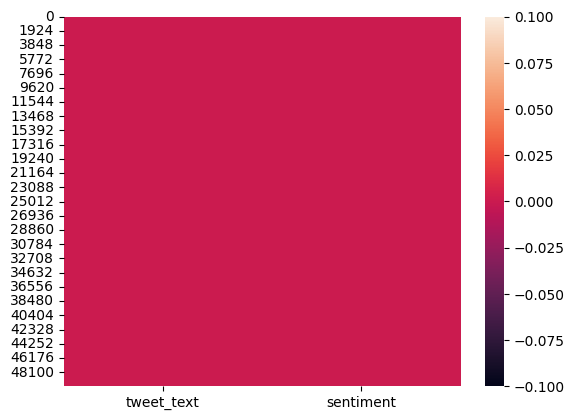

In [13]:
sns.heatmap(pd.isnull(base_treinamento));

## Base de teste

In [17]:
base_teste = pd.read_csv('/content/Test.csv', delimiter=';')

In [18]:
base_teste.head()

,id,tweet_text,tweet_date,sentiment,query_used
0,1029536486021099522,@Gazo1a Nossa! Muito obrigada :),Wed Aug 15 01:13:20 +0000 2018,1,:)
1,1029536496368406528,@BerzGamer vai pa puta que te pariu :),Wed Aug 15 01:13:23 +0000 2018,1,:)
2,1029536531655131137,QUER MAIS DESCONTOS? (14/08) ⭐⭐⭐⭐⭐ 🌐 Confira n...,Wed Aug 15 01:13:31 +0000 2018,1,:)
3,1029536560117678081,"EU VOU PEGAR VCS, ME AJUDEM GALERA, PELO AMOR ...",Wed Aug 15 01:13:38 +0000 2018,1,:)
4,1029536605852377088,Estávamos em casa do Zé e eu estava a morrer d...,Wed Aug 15 01:13:49 +0000 2018,1,:)


In [19]:
base_teste.shape

(5000, 5)

In [20]:
base_teste.drop(['id', 'tweet_date', 'query_used'], axis = 1, inplace=True)

In [21]:
base_teste.head()

,tweet_text,sentiment
0,@Gazo1a Nossa! Muito obrigada :),1
1,@BerzGamer vai pa puta que te pariu :),1
2,QUER MAIS DESCONTOS? (14/08) ⭐⭐⭐⭐⭐ 🌐 Confira n...,1
3,"EU VOU PEGAR VCS, ME AJUDEM GALERA, PELO AMOR ...",1
4,Estávamos em casa do Zé e eu estava a morrer d...,1


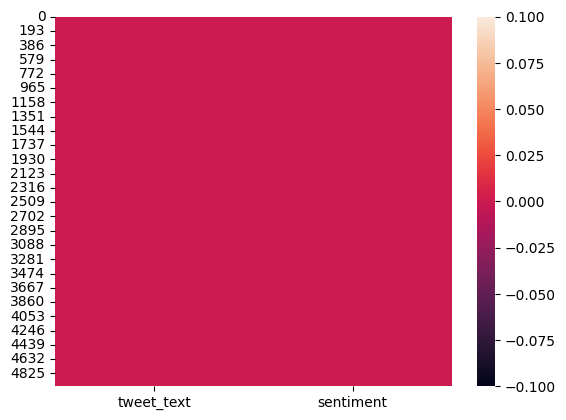

In [22]:
sns.heatmap(pd.isnull(base_teste));

# Função para pré-processamento dos textos

- Letras minúsculas
- Nome do usuário (@)
- URLs
- Espaços em branco
- Emoticons
- Stop words
- Lematização
- Pontuações

In [23]:
pln = en_core_web_sm.load()
pln

In [24]:
from spacy.lang.pt.stop_words import STOP_WORDS

In [25]:
stop_words = STOP_WORDS

In [26]:
def preprocessamento(texto):
  # Letras minúsculas
  texto = texto.lower()

  # Nome do usuário
  texto = re.sub(r"@[A-Za-z0-9$-_@.&+]+", ' ', texto)

  # URLs
  texto = re.sub(r"https?://[A-Za-z0-9./]+", ' ', texto)

  # Espaços em branco
  texto = re.sub(r" +", ' ', texto)

  # Emoticons
  lista_emocoes = {':)': 'emocaopositiva',
                   ':d': 'emocaopositiva',
                   ':(': 'emocaonegativa'}
  for emocao in lista_emocoes:
    texto = texto.replace(emocao, lista_emocoes[emocao])

  # Lematização
  documento = pln(texto)

  lista = []
  for token in documento:
    lista.append(token.lemma_)

  # Stop words e pontuações
  lista = [palavra for palavra in lista if palavra not in stop_words and palavra not in string.punctuation]
  lista = ' '.join([str(elemento) for elemento in lista if not elemento.isdigit()])

  return lista

# Pré-processamento da base de dados

### Limpeza dos textos

In [27]:
base_treinamento.head(10)

,tweet_text,sentiment
0,@Laranjito76 A pessoa certa para isso seria o ...,1
1,"@behin_d_curtain Para mim, é precisamente o co...",1
2,Vou fazer um video hoje... estou pensando em f...,1
3,"aaaaaaaa amei tanto essas polaroids, nem sei e...",1
4,Valoriza o coração do menininho que vc tem. El...,1
5,@KingJokerLeto mas amiga eu to aqui ainda :),1
6,"@RivasJairo Bravo, Jairo!!! :)))",1
7,@inquilinasls @Spotify socorro ksoaksosks acho...,1
8,"@chimekarlla gosto muito de fazenda :) , mas m...",1
9,Amanha vou ver venom :D,1


In [28]:
base_treinamento['tweet_text'] = base_treinamento['tweet_text'].apply(preprocessamento)

In [29]:
base_treinamento.head(10)

,tweet_text,sentiment
0,pessoa certa vale azevedo emocaopositiva,1
1,mim precisamente contrário emocaopositiva ch...,1
2,vou video hoje ... pensando falar meta csgo pa...,1
3,aaaaaaaa amei polaroid expressar to apaixonada...,1
4,valoriza coração menininho vc diferente faça s...,1
5,amiga to emocaopositiva,1
6,bravo jairo emocaopositiva,1
7,socorro ksoaksosk acho to usando caixinha so...,1
8,gosto fazenda emocaopositiva morro medo gali...,1
9,amanha vou venom emocaopositiva,1


In [32]:
base_teste['tweet_text'] = base_teste['tweet_text'].apply(preprocessamento)

In [33]:
base_teste.head(10)

,tweet_text,sentiment
0,emocaopositiva,1
1,pa puta pariu emocaopositiva,1
2,desconto 14/08 ⭐ ⭐ ⭐ ⭐ ⭐ 🌐 confira link ➔ » co...,1
3,vou vcs I ajudem galera amor butera emocaoposi...,1
4,estávamos casa zé morrer sono chego casa fico ...,1
5,precisa emocaopositiva,1
6,acaso adoro beijos abraços hahahahaha bue fo...,1
7,solteiro s sozinho emocaopositiva,1
8,lindezas cortador kit mário coleção bia cravol...,1
9,claro emocaopositiva,1


### Tratamento da classe

In [34]:
exemplo_base_dados = [["este trabalho é agradável", {"POSITIVO": True, "NEGATIVO": False}],
                      ["este lugar continua assustador", {"POSITIVO": False, "NEGATIVO": True}]]

In [35]:
base_dados_treinamento_final = []
for texto, emocao in zip(base_treinamento['tweet_text'], base_treinamento['sentiment']):
  if emocao == 1:
    dic = ({'POSITIVO': True, 'NEGATIVO': False})
  elif emocao == 0:
    dic = ({'POSITIVO': False, 'NEGATIVO': True})

  base_dados_treinamento_final.append([texto, dic.copy()])

In [36]:
len(base_dados_treinamento_final)

50000

In [37]:
base_dados_treinamento_final[10:15]

[['simplesmente I deixam chateada coisas muitooo I iludir emocaopositiva',
  {'POSITIVO': True, 'NEGATIVO': False}],
 ['começa rotina perfeitamente consolidar escola condução :p',
  {'POSITIVO': True, 'NEGATIVO': False}],
 ['amigo apaixonado vc — recíproco emocaopositiva',
  {'POSITIVO': True, 'NEGATIVO': False}],
 ['  gajo bacano vê I aleijas espero silva sejam felize emocaopositiva',
  {'POSITIVO': True, 'NEGATIVO': False}],
 ['tou video cabrinhas bebés emocaopositiva',
  {'POSITIVO': True, 'NEGATIVO': False}]]

In [38]:
base_dados_treinamento_final[45000:45005]

[['menino pijama listrado filme triste mundo estrutura pra assistir rever to pensando nisso emocaonegativa',
  {'POSITIVO': False, 'NEGATIVO': True}],
 ['pra ido vídeo luísa raiz poliana infelizmente twitter tá ruim amanhã tento postar emocaonegativa asaventurasdepoliana099',
  {'POSITIVO': False, 'NEGATIVO': True}],
 ['to crise abstinência stranger emocaonegativa — tbm :/ to tentando',
  {'POSITIVO': False, 'NEGATIVO': True}],
 ['  tinha esquecido olhar pra pagar mensalidade turma pro curso emocaonegativa',
  {'POSITIVO': False, 'NEGATIVO': True}],
 ['comer doce comi monte hoje emocaonegativa maldição',
  {'POSITIVO': False, 'NEGATIVO': True}]]

# Criação do classificador

In [39]:
modelo = spacy.blank('pt')
categorias = modelo.add_pipe("textcat")
categorias.add_label("POSITIVO")
categorias.add_label("NEGATIVO")
historico = []

/usr/local/lib/python3.10/dist-packages/spacy/util.py:1740: UserWarning: [W111] Jupyter notebook detected: if using `prefer_gpu()` or `require_gpu()`, include it in the same cell right before `spacy.load()` to ensure that the model is loaded on the correct device. More information: http://spacy.io/usage/v3#jupyter-notebook-gpu
  warnings.warn(Warnings.W111)


In [40]:
from spacy.training import Example

In [41]:
modelo.begin_training()
for epoca in range(5):
  random.shuffle(base_dados_treinamento_final)
  losses = {}
  for batch in spacy.util.minibatch(base_dados_treinamento_final, 512):
    textos = [modelo(texto) for texto, entities in batch]
    annotations = [{'cats': entities} for texto, entities in batch]
    examples = [Example.from_dict(doc, annotation) for doc, annotation in zip(
        textos, annotations
      )]
    modelo.update(examples, losses=losses)
    historico.append(losses)
  if epoca % 5 == 0:
    print(losses)

{'textcat': 1.7359746886964444}


In [42]:
historico_loss = []
for i in historico:
  historico_loss.append(i.get('textcat'))

In [43]:
historico_loss = np.array(historico_loss)
historico_loss

array([1.73597469e+00, 1.73597469e+00, 1.73597469e+00, 1.73597469e+00,
       1.73597469e+00, 1.73597469e+00, 1.73597469e+00, 1.73597469e+00,
       1.73597469e+00, 1.73597469e+00, 1.73597469e+00, 1.73597469e+00,
       1.73597469e+00, 1.73597469e+00, 1.73597469e+00, 1.73597469e+00,
       1.73597469e+00, 1.73597469e+00, 1.73597469e+00, 1.73597469e+00,
       1.73597469e+00, 1.73597469e+00, 1.73597469e+00, 1.73597469e+00,
       1.73597469e+00, 1.73597469e+00, 1.73597469e+00, 1.73597469e+00,
       1.73597469e+00, 1.73597469e+00, 1.73597469e+00, 1.73597469e+00,
       1.73597469e+00, 1.73597469e+00, 1.73597469e+00, 1.73597469e+00,
       1.73597469e+00, 1.73597469e+00, 1.73597469e+00, 1.73597469e+00,
       1.73597469e+00, 1.73597469e+00, 1.73597469e+00, 1.73597469e+00,
       1.73597469e+00, 1.73597469e+00, 1.73597469e+00, 1.73597469e+00,
       1.73597469e+00, 1.73597469e+00, 1.73597469e+00, 1.73597469e+00,
       1.73597469e+00, 1.73597469e+00, 1.73597469e+00, 1.73597469e+00,
      

Text(0, 0.5, 'Erro')

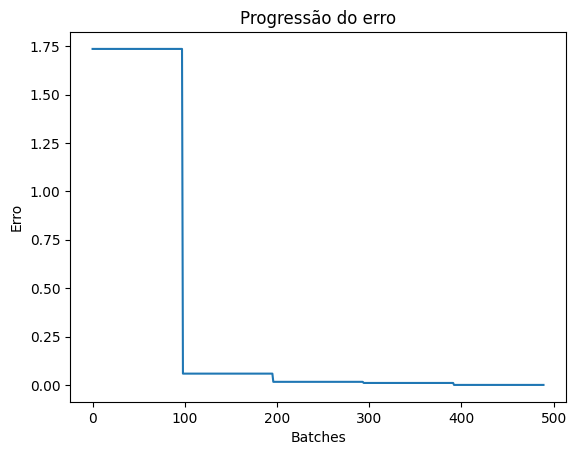

In [44]:
import matplotlib.pyplot as plt
plt.plot(historico_loss)
plt.title('Progressão do erro')
plt.xlabel('Batches')
plt.ylabel('Erro')

In [45]:
modelo.to_disk("modelo")

# Testes com uma frase

In [46]:
modelo_carregado = spacy.load('modelo')
modelo_carregado

## Texto positivo

In [47]:
texto_positivo = base_teste['tweet_text'][21]
texto_positivo

'  fico feliz sabendo q recíproco emocaopositiva'

In [48]:
previsao = modelo_carregado(texto_positivo)
previsao

  fico feliz sabendo q recíproco emocaopositiva

In [49]:
previsao.cats

{'POSITIVO': 0.9999998807907104, 'NEGATIVO': 6.504320992917201e-08}

In [50]:
texto_positivo = 'eu gosto muito de você'
texto_positivo = preprocessamento(texto_positivo)
texto_positivo

'gosto'

In [51]:
modelo_carregado(texto_positivo).cats

{'POSITIVO': 0.9983986020088196, 'NEGATIVO': 0.0016013361746445298}

## Texto negativo

In [52]:
base_teste['tweet_text'][4000]

'tô triste filme mulan mushu emocaonegativa'

In [53]:
texto_negativo = base_teste['tweet_text'][4000]
previsao = modelo_carregado(texto_negativo)
previsao.cats

{'POSITIVO': 5.507462574882993e-08, 'NEGATIVO': 1.0}

# Avaliação do modelo

In [54]:
previsoes = []
for texto in base_teste['tweet_text']:
  previsao = modelo_carregado(texto)
  previsoes.append(previsao.cats)

In [55]:
previsoes_final = []
for previsao in previsoes:
  if previsao['POSITIVO'] > previsao['NEGATIVO']:
    previsoes_final.append(1)
  else:
    previsoes_final.append(0)

previsoes_final = np.array(previsoes_final)

In [56]:
respostas_reais = base_teste['sentiment'].values

In [57]:
from sklearn.metrics import accuracy_score
accuracy_score(respostas_reais, previsoes_final)

0.9976

In [58]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(respostas_reais, previsoes_final)
cm

array([[2495,    5],
       [   7, 2493]])

<Axes: >

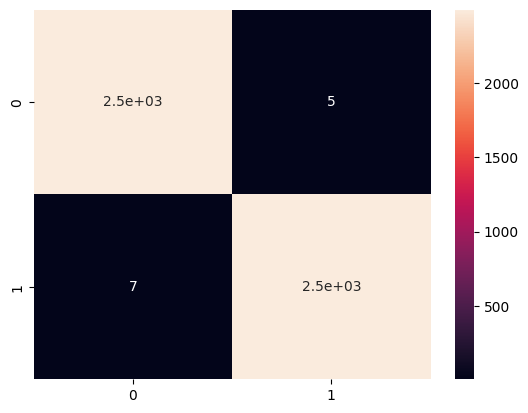

In [59]:
sns.heatmap(cm, annot=True)